In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
maxr = s.galrad
maxr = 0.01 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [$(\x0crac{km}{s})^2]$')

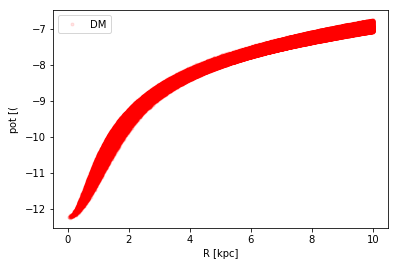

In [5]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]$')

In [6]:
print(np.min(vR_kms))

0.24112


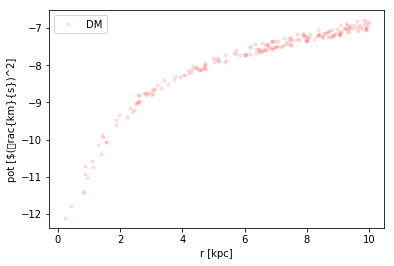

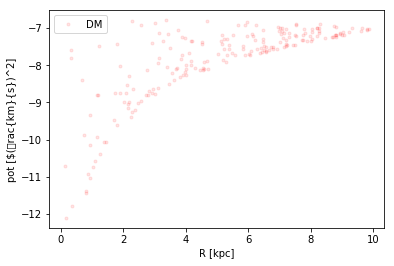

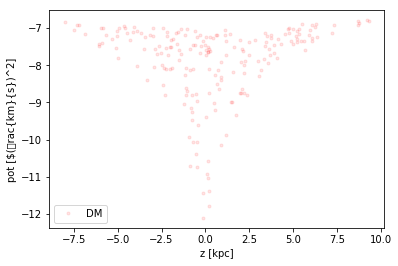

In [17]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)),201))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]

R_kpc_data,z_kpc_data,pot_kms2_data = rand_R_dm, rand_z_dm, rand_pot_dm

plt.plot(rand_r_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()
plt.plot(rand_R_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()
plt.plot(rand_z_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('z [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()


In [22]:
#_____reference values for galpy_____
_REFR0_kpc = 4.

In [23]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    bulge = HernquistPotential(
                a=a_HB,
                normalize=n_HB)
    return [disk,halo,bulge]
    #return [disk,halo]

Scipy differential_evolution
----


In [24]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    '''
    INPUT: x: parameters to be fitted
               x[0]: v0 [km/s]
               x[1], x[2]: scale lengths of Miyamoto Nagai disk [kpc]
               x[3], x[4]: scale length of MFW and Hernquist halo and bulge potentials [kpc]
               x[5], x[6]: normalization of MND and NFWH (including normalization of HB by subtracting them from 1)
           args: data
               args[0], args[1]: grid of R and z in kpc
               args[2]: potential in (km/s)**2
    OUTPUT: err: sum of relative error squares
    '''
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = 1.-n_NFWH-n_MND
    
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB)
        #print('Setup potential works.')
    except Exception as e:
        #uncomment for debugging:
        #print(e.message)
        #print(x)
        return np.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(((pot_kms2_data - pot_kms2_model) / pot_kms2_model)**2)
    #print(err)
    return err

In [27]:
lower_floor = 1e-3
bounds = ((lower_floor,400.), #vcirc
          (lower_floor,15.), #a_MND
          (lower_floor,10.), #b_MND
          (lower_floor,50.), #a_NFWH
          (lower_floor,10.), #a_HB
          (0.,1.), #n_MND
          (0.,1.)) #n_NFWH

#fitting:
res = opt.differential_evolution(
            rel_pot_error_scipydifferentialevolution,
            bounds=bounds,
            args=(R_kpc_data,z_kpc_data,pot_kms2_data),
            strategy='best1bin',
            maxiter=10000,tol=0.001,atol=1e-7,
            disp=False
            )

print(res)
print("best fit:")
print("v0_kms    ", res.x[0])
print("a_MND_kpc ", res.x[1])
print("b_MND_kpc ", res.x[2])
print("a_NFWH_kpc", res.x[3])
print("a_HB_kpc  ", res.x[4])
print("n_MND     ", res.x[5])
print("n_NFWH    ", res.x[6])
print("n_HB      ", 1.-res.x[5]-res.x[6])


/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)

     fun: 0.010604893872823032
 message: 'Optimization terminated successfully.'
    nfev: 49164
     nit: 467
 success: True
       x: array([  1.23073958e+00,   1.49806012e+01,   7.52939655e-02,
         4.99725171e+01,   1.32514179e+00,   4.90033734e-02,
         1.39238148e-01])
best fit:
v0_kms     1.23073958063
a_MND_kpc  14.9806012106
b_MND_kpc  0.0752939654645
a_NFWH_kpc 49.972517066
a_HB_kpc   1.32514178542
n_MND      0.0490033734298
n_NFWH     0.139238148425
n_HB       0.811758478146


if not working try to fit without HB

emcee fitting
----

In [30]:
#_____function for MCMC, sum of error squares_____
def lnprob_MCMC(x,*args):
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = 1.-n_NFWH-n_MND
    
    #check if imput parameters are physical:
    if v0_kms <= 0: return -np.inf
    #(Note: all other parameters are checked during setting up the galpy potential.)
        
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB)
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return -np.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(-0.5*(pot_kms2_data-pot_kms2_model)**2)
    return err

In [31]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 7, 50, 1000

#initial values for fit:
v0_kms_init     = 150.
a_MND_kpc_init  = 6.
b_MND_kpc_init  = 1.
a_NFWH_kpc_init = 10.
a_HB_kpc_init   = 2.
n_MND_init      = 0.2
n_NFWH_init     = 0.6
initial_guess = np.array([v0_kms_init,a_MND_kpc_init,b_MND_kpc_init,a_NFWH_kpc_init,a_HB_kpc_init,
                             n_MND_init,n_NFWH_init])
initial_guess_width = np.fabs(0.2*initial_guess)
p0 = np.array([np.random.randn(ndim)*np.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])
#fiitting boundaries:
boundaries = np.array([[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,1.],[0.,1.]])
for pp in range(ndim):
    p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + np.random.uniform() * 0.1
    p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - np.random.uniform() * 0.1

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 500
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

/home/extmilan/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0

/home/extmilan/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))



In [32]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = np.percentile(final_samples,[16.,50.,84.],axis=0)
median = np.median(final_samples,axis=0)
std = np.std(final_samples,axis=0)
print("true vs. best fit:")
print("v0_kms    ",median[0],"\t","+/-",std[0])
print("a_MND_kpc ",median[1],"\t","+/-",std[1])
print("b_MND_kpc ",median[2],"\t","+/-",std[2])
print("a_NFWH_kpc",median[3],"\t","+/-",std[3])
print("a_HB_kpc  ",median[4],"\t","+/-",std[4])
print("n_MND     ",median[5],"\t","+/-",std[5])
print("n_NFWH    ",median[6],"\t","+/-",std[6])
print("n_HB      ",1.-median[5]-median[6])

true vs. best fit:
v0_kms     1.27709294726 	 +/- 0.0893359460756
a_MND_kpc  7.16711506806 	 +/- 5.16437764978
b_MND_kpc  2.68018471504 	 +/- 3.88366319513
a_NFWH_kpc 15.7602127799 	 +/- 12.1576601742
a_HB_kpc   1.95713231544 	 +/- 3.54128322195
n_MND      0.141812460509 	 +/- 0.115841457227
n_NFWH     0.241220168315 	 +/- 0.202556352955
n_HB       0.616967371176


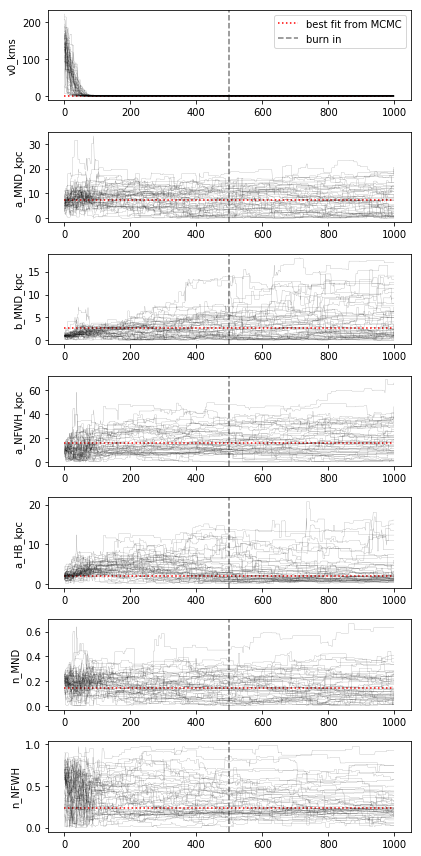

In [33]:
#plot progress
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(np.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = np.percentile(final_samples[:,ii],[50.])
    #ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()

In [34]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 7, 50, 1000

#initial values for fit:
initial_guess = median
initial_guess_width = 0.1*std
p0 = np.array([np.random.randn(ndim)*np.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 700
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

In [35]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = np.percentile(final_samples,[16.,50.,84.],axis=0)
median = np.median(final_samples,axis=0)
std = np.std(final_samples,axis=0)
print("true vs. best fit:")
print("v0_kms    ",median[0],"\t","+/-",std[0])
print("a_MND_kpc ",median[1],"\t","+/-",std[1])
print("b_MND_kpc ",median[2],"\t","+/-",std[2])
print("a_NFWH_kpc",median[3],"\t","+/-",std[3])
print("a_HB_kpc  ",median[4],"\t","+/-",std[4])
print("n_MND     ",median[5],"\t","+/-",std[5])
print("n_NFWH    ",median[6],"\t","+/-",std[6])
print("n_HB      ",1.-median[5]-median[6])

true vs. best fit:
v0_kms     1.24638608964 	 +/- 0.0641848256114
a_MND_kpc  8.00498841463 	 +/- 10.397372925
b_MND_kpc  4.66920505739 	 +/- 6.55041871314
a_NFWH_kpc 19.6846262841 	 +/- 10.5319591677
a_HB_kpc   1.25980854786 	 +/- 1.91390677848
n_MND      0.0751509506475 	 +/- 0.0708408146257
n_NFWH     0.267246058975 	 +/- 0.146123857121
n_HB       0.657602990378


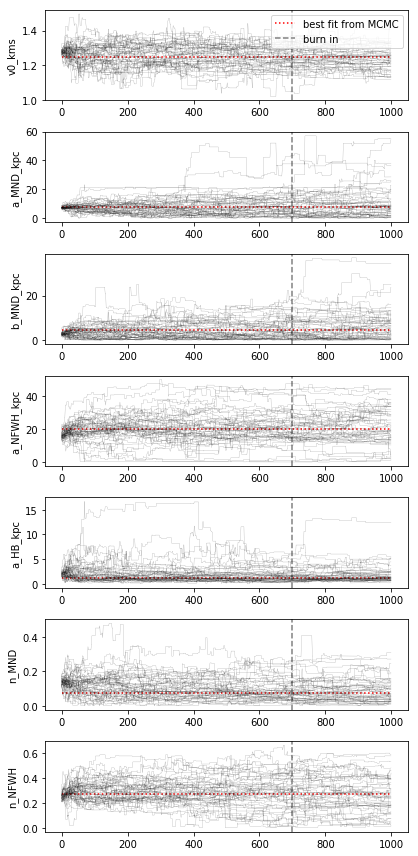

In [36]:
#plot progress
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(np.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = np.percentile(final_samples[:,ii],[50.])
    #ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()

In [8]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 

def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r = None, R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    #n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    #hep = HEpot(a = a_he, normalize = n_he)
    pot = [mp, nfwp]#, hep]         
    pot_mod = np.zeros((len(z), len(R)))
    for ii, zii in enumerate(z):
        for jj, Rjj in enumerate(R):
            pot_mod[ii, jj] = evaluatePotentials(pot, Rjj/r0, zii/r0)
    return pot_mod

# FITTING

def RMS(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydat = pot
    yfit = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0) * v0**2
    RMS = np.sqrt(1./N*np.sum((ydat - yfit)**2))
    #chi = np.sum((yfit - ydat)**2/(ydat))
    #print(datetime.datetime.now().time())
    #print(RMS)
    #print(chi)
    #print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    print(RMS)
    return RMS

def chi(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydat = pot
    yfit = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0) * v0**2
    #RMS = np.sqrt(1./N*np.sum((ydat - yfit)**2))
    chi = np.abs(np.sum((yfit - ydat)**2/(ydat)))
    #print(datetime.datetime.now().time())
    #print(RMS)
    #print(chi)
    #print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    return chi

def rel_error(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydat = pot
    yfit = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0) * v0**2
    #RMS = np.sqrt(1./N*np.sum((ydat - yfit)**2))
    #chi = np.abs(np.sum((yfit - ydat)**2/(ydat)))
    rel_err = np.abs(np.sum((yfit - ydat)**2/(ydat**2)))
    #print(datetime.datetime.now().time())
    #print(RMS)
    #print(chi)
    #print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    return rel_err

a_mp = 0.5 
b_mp = 0.1#0.0375 
n_mp = 0.6  
a_nfw = 3 #4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 

v0 = 200.

pot = rand_pot_dm
r, R, z = rand_r_dm, rand_R_dm, rand_z_dm
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , v0) #n_he

bounds = ((0., None), (0., None), (0., 0.999), (0., None), (0., 0.999), (0., None)) #n_he
#r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0 = 8.
N = len(r)
# v0 muss mitgefittet werden
print(x0)

cons = ({'type': 'eq', 'fun': lambda x:  1. - (x[2] + x[4] )})

res_rms = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds, constraints = cons)
res_chi = opt.minimize(rel_error, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds, constraints = cons)

(0.5, 0.1, 0.6, 3, 0.35, 200.0)
1481512.77161
1481512.77161
1481512.77417
1481512.77654
1481512.78087
1481512.77579
1481512.81882
1481512.77183
/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:823: RuntimeWarning: divide by zero encountered in double_scalars
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:803: RuntimeWarning: divide by zero encountered in double_scalars
  return -numpy.log(1.+r/self.a)/r

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/Potential.py:264: RuntimeWarning: invalid value encountered in double_scalars
  else: return self._amp*rawOut



In [9]:
res_rms


     fun: 1481512.7716125143
     jac: array([  171578.25    ,   330746.890625,   621192.640625,   280087.0625  ,
        3168217.328125,    14815.90625 ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([  5.00000000e-01,   1.00000000e-01,   6.00000000e-01,
         3.00000000e+00,   3.50000000e-01,   2.00000000e+02])

In [10]:
res_chi

     fun: 1858404138825.8464
     jac: array([  4.35883033e+11,   9.15191431e+11,   1.68801981e+12,
         7.25451784e+11,   8.37116990e+12,   4.13009019e+10])
 message: 'Inequality constraints incompatible'
    nfev: 17
     nit: 3
    njev: 2
  status: 4
 success: False
       x: array([  4.50000000e-01,   9.00000000e-02,   6.39900000e-01,
         2.70000000e+00,   3.15000000e-01,   1.80000000e+02])

In [11]:
a_mp_rms, b_mp_rms, n_mp_rms = res_rms.x[0], res_rms.x[1], res_rms.x[2]
a_nfw_rms , n_nfw_rms = res_rms.x[3]  , res_rms.x[4]
#a_he, n_he = res.x[5],  res.x[6]
a_mp_chi, b_mp_chi, n_mp_chi = res_chi.x[0], res_chi.x[1], res_chi.x[2]
a_nfw_chi , n_nfw_chi = res_chi.x[3]  , res_chi.x[4]

In [12]:
mp_rms = MNpot(a = a_mp_rms, b = b_mp_rms, normalize = n_mp_rms, ro = r0, vo = v0)
nfwp_rms = NFWpot(a = a_nfw_rms, normalize = n_nfw_rms, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot_rms = [mp_rms,nfwp_rms]#,hep]

mp_chi = MNpot(a = a_mp_chi, b = b_mp_chi, normalize = n_mp_chi, ro = r0, vo = v0)
nfwp_chi = NFWpot(a = a_nfw_chi, normalize = n_nfw_chi, ro = r0, vo = v0)
    
pot_chi = [mp_chi,nfwp_chi]#,hep]

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

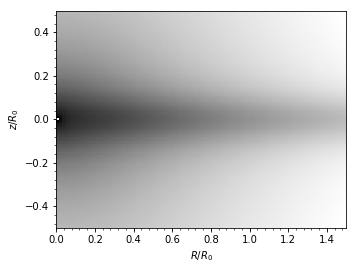

In [13]:
plotDensities(pot_rms,nrs=101,nzs=101, log = True)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

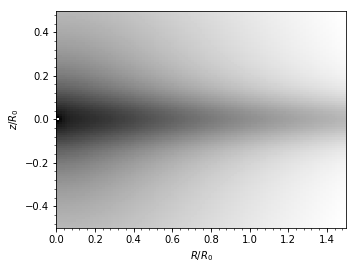

In [14]:
plotDensities(pot_chi,nrs=101,nzs=101, log = True)